In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV ,cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from xgboost import XGBRegressor
import tensorflow as tf
import pickle
import string
import re
import numpy as np
import statistics
import math
import time
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_pickle('preprocess_data.pkl')

train = data.loc[data.flag=='train',:]
print(train.shape)
test = data.loc[data.flag=='test',:]
print(test.shape)

train.drop(columns=['flag'],inplace=True)
test.drop(columns=['flag'],inplace=True)


(55284, 30)
(29769, 30)


In [3]:
train.isnull().sum().sort_values(ascending=False)

neighborhood_overview          19506
host_response_time             17802
host_response_rate             17802
space                          16881
summary                         2954
host_has_profile_pic             111
host_identity_verified           111
host_since                       111
host_is_superhost                111
name                              14
guests_included                    0
review_scores_value                0
review_scores_location             0
review_scores_communication        0
reviews_per_month                  0
review_scores_checkin              0
review_scores_cleanliness          0
review_scores_accuracy             0
review_scores_rating               0
bedrooms                           0
price                              0
amenities                          0
bed_type                           0
beds                               0
bathrooms                          0
accommodates                       0
property_type                      0
h

In [4]:
##### Null treatment

def treat_null(df):
    for c in ['host_has_profile_pic','host_is_superhost','host_identity_verified','host_response_rate','host_response_time']:
        df[c].fillna(0,inplace=True)
    df['neighborhood_overview'].fillna('',inplace=True)
    df['space'].fillna('',inplace=True)
    df['summary'].fillna('',inplace=True)
    df['host_since'].fillna(statistics.median(df['host_since'].dropna().tolist()),inplace=True)
    return df


train = treat_null(train)
test = treat_null(test)

train.isnull().sum().sort_values(ascending=False)
    

name                           14
beds                            0
reviews_per_month               0
review_scores_value             0
review_scores_location          0
review_scores_communication     0
review_scores_checkin           0
review_scores_cleanliness       0
review_scores_accuracy          0
review_scores_rating            0
guests_included                 0
price                           0
amenities                       0
bed_type                        0
bedrooms                        0
summary                         0
bathrooms                       0
accommodates                    0
property_type                   0
host_identity_verified          0
host_has_profile_pic            0
host_total_listings_count       0
host_is_superhost               0
host_response_rate              0
host_response_time              0
host_since                      0
neighborhood_overview           0
space                           0
listing_id                      0
dtype: int64

In [5]:
###### Feature identification

target_col = 'price'
id_col = 'listing_id'
text_cols = ['name','summary','space','neighborhood_overview']
numeric_cols = [c for c in train.columns if c not in [target_col]+[id_col]+text_cols]


### Modeling with only numeric features

In [6]:
features = train.dropna()
X = features[[c for c in numeric_cols]]
y = features[target_col]

In [7]:
X.isnull().sum().sort_values(ascending=False)


host_since                     0
bed_type                       0
review_scores_value            0
review_scores_location         0
review_scores_communication    0
review_scores_checkin          0
review_scores_cleanliness      0
review_scores_accuracy         0
review_scores_rating           0
guests_included                0
amenities                      0
beds                           0
host_response_time             0
bedrooms                       0
bathrooms                      0
accommodates                   0
property_type                  0
host_identity_verified         0
host_has_profile_pic           0
host_total_listings_count      0
host_is_superhost              0
host_response_rate             0
reviews_per_month              0
dtype: int64

In [8]:
print(X.shape)
print(len(y))

(55270, 23)
55270


In [9]:
X_train, X_val,y_train,y_val = train_test_split(X,y, test_size=0.2, random_state=1)
print(X_train.shape, X_val.shape)

(44216, 23) (11054, 23)


### Models with only numeric features

##### Baseline Model preparation

- models : Linear Regression, Support Vector Machine, Decision Tree, Random Forest, Adaptive Boosting, Extreme Gradient Boosting 
- included all the features with no hyperparameter tuning and no outlier removal
- evaluation metrics: R-square, mean absolute error, mean percentage error

In [10]:


models = [LinearRegression(), LinearSVR(), DecisionTreeRegressor(),
        RandomForestRegressor(), AdaBoostRegressor(), XGBRegressor()]

cv = KFold(n_splits=10)


def multiple_scoring(actual, pred):
        rmse = round(mean_squared_error(actual, pred, squared=False),3) 
        r2 =  round(r2_score(actual, pred),3)
        mae = round(mean_absolute_error(actual, pred),3)
        mape = round(mean_absolute_percentage_error(actual, pred),3)
        return [rmse, r2, mae, mape]
        



def show_baseline_performance(Xtrain, ytrain, Xtest, ytest):
        baseline_df = pd.DataFrame([], columns=['model_name','train_rmse','train_r2','train_mae','train_mape',
                                                'val_rmse','val_r2','val_mae','val_mape','time_taken'])
        for model in models:
                result_list = []
                result_list.append(str(model).split('(')[0])
                start = time.time()
                model.fit(Xtrain, ytrain)
                yfit = model.predict(Xtrain)
                result_list.extend(multiple_scoring(ytrain, yfit))
                ypred = model.predict(Xtest)
                result_list.extend(multiple_scoring(ytest, ypred))
                stop = time.time()
                result_list.append(round(stop - start, 2))
                baseline_df.loc[len(baseline_df.index)] = result_list
        return baseline_df


In [11]:
baseline_df = show_baseline_performance(X_train, y_train, X_val, y_val)
baseline_df.sort_values(by=['val_rmse','val_mape'], ascending=True)

,model_name,train_rmse,train_r2,train_mae,train_mape,val_rmse,val_r2,val_mae,val_mape,time_taken
5,XGBRegressor,46.941,0.687,30.535,0.389,54.994,0.561,35.407,0.431,1.86
3,RandomForestRegressor,25.452,0.908,15.239,0.199,56.173,0.542,36.470,0.453,39.63
0,LinearRegression,62.607,0.444,41.070,0.551,62.160,0.439,41.346,0.540,0.09
4,AdaBoostRegressor,65.074,0.399,48.066,0.736,64.293,0.400,47.719,0.717,1.25
1,LinearSVR,67.029,0.362,40.145,0.408,66.753,0.353,40.524,0.399,10.36
2,DecisionTreeRegressor,16.157,0.963,3.488,0.055,76.907,0.141,48.177,0.567,0.68


#### Linear Regression

In [12]:
# feature selection

def select_linear_features(X_train, y_train, X_val, score_func):
	scale = StandardScaler().fit(X_train)
	X_train = scale.transform(X_train)
	X_val = scale.transform(X_train)
	fs = SelectKBest(score_func=score_func, k=15)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_val_fs = fs.transform(X_val)
	return X_train_fs, X_val_fs



cv = KFold(n_splits=10)
# feature selection
X_train_k, X_val_k = select_linear_features(X_train, y_train, X_val, mutual_info_regression)
model = LinearRegression()
cv_score = cross_val_score(model,X_train_k,y_train,scoring='neg_mean_absolute_percentage_error',cv=cv)
print("MSE: mean {:.2f} std {:.3f}".format(statistics.mean(cv_score)*-1, statistics.stdev(cv_score)))

# model.fit(X_train_fs, y_train)
# # evaluate the model
# yhat = model.predict(X_test_fs)
# # evaluate predictions
# mae = mean_absolute_error(y_test, yhat)
# print('MAE: %.3f' % mae)





MSE: mean 0.55 std 0.008


##### Decision Tree Regressor

In [13]:

params = {'max_depth':np.arange(2,6),
        'min_samples_leaf':np.arange(0,1.0,0.1),
        }


def tune_dt():
    result_df = pd.DataFrame([],columns=['type','rmse','r2','mae','mape'])
    train_results = ['train']
    val_results = ['val']
    tuner = GridSearchCV(DecisionTreeRegressor(), params, refit=True,
                            scoring='neg_mean_absolute_percentage_error',
                            cv=10)
    tuner.fit(X_train, y_train)
    print(f"Best Parameters: \n{tuner.best_params_}")
    best_model = tuner.best_estimator_
    yfit = best_model.predict(X_train)
    train_results.extend(multiple_scoring(y_train, yfit))
    result_df.loc[len(result_df.index)] = train_results
    ypred = best_model.predict(X_val)
    val_results.extend(multiple_scoring(y_val,ypred))
    result_df.loc[len(result_df.index)] = val_results
    return result_df

dt_results = tune_dt()
dt_results.head()


Best Parameters: 
{'max_depth': 5, 'min_samples_leaf': 0.1}


,type,rmse,r2,mae,mape
0,train,65.749,0.386,43.055,0.545
1,val,64.486,0.396,42.584,0.537


##### RandomForest Regression

In [14]:

params = {'n_estimators':[100,200,500],
        'max_depth':np.arange(2,6),
        'min_samples_leaf':np.arange(0,0.5,0.1),
        'min_weight_fraction_leaf':np.arange(0,0.5,0.1),
        }


def tune():
    result_df = pd.DataFrame([],columns=['type','rmse','r2','mae','mape'])
    train_results = ['train']
    val_results = ['val']
    tuner = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1), params, refit=True,
                            scoring='neg_mean_absolute_percentage_error',
                            verbose=10, cv=10, n_iter=50)
    tuner.fit(X_train, y_train)
    print(f"Best Parameters: \n{tuner.best_params_}")
    best_model = tuner.best_estimator_
    yfit = best_model.predict(X_train)
    train_results.extend(multiple_scoring(y_train, yfit))
    result_df.loc[len(result_df.index)] = train_results
    ypred = best_model.predict(X_val)
    val_results.extend(multiple_scoring(y_val,ypred))
    result_df.loc[len(result_df.index)] = val_results
    return result_df

rf_results = tune()
rf_results.head()


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10; 1/50] START max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200
[CV 1/10; 1/50] END max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200;, score=-0.956 total time=   4.7s
[CV 2/10; 1/50] START max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200
[CV 2/10; 1/50] END max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200;, score=-0.921 total time=   0.5s
[CV 3/10; 1/50] START max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200
[CV 3/10; 1/50] END max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200;, score=-0.927 total time=   0.6s
[CV 4/10; 1/50] START max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200
[CV 4/10; 1/50] END max_depth=4, min_samples_leaf=0.4, min_weight_fraction_leaf=0.1, n_estimators=200;, score=-0.

,type,rmse,r2,mae,mape
0,train,67.904,0.345,45.115,0.592
1,val,66.325,0.361,44.498,0.580


##### Extreme Gradient Boosting Regression

In [19]:

params = {'n_estimators':np.arange(100,600,100),
        'max_depth':np.arange(2,7),
        'min_child_weight':np.arange(0,0.5,0.1),
        'colsample_bytree':np.arange(0.5,1.,0.1)
        }


def tune():
    result_df = pd.DataFrame([],columns=['type','rmse','r2','mae','mape'])
    train_results = ['train']
    val_results = ['val']
    tuner = RandomizedSearchCV(XGBRegressor(booster='gbtree',n_jobs=-1), params, refit=True,
                            scoring='neg_mean_absolute_percentage_error',
                            verbose=2, cv=10, n_iter=50)
    tuner.fit(X_train, y_train)
    print(f"Best Parameters: \n{tuner.best_params_}")
    best_model = tuner.best_estimator_
    yfit = best_model.predict(X_train)
    train_results.extend(multiple_scoring(y_train, yfit))
    result_df.loc[len(result_df.index)] = train_results
    ypred = best_model.predict(X_val)
    val_results.extend(multiple_scoring(y_val,ypred))
    result_df.loc[len(result_df.index)] = val_results
    return result_df

xgb_results = tune()
xgb_results.head()


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   4.2s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.9s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.8s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.8s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.8s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.7s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.7s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.9s
[CV] END colsample_bytree=0.7, max_depth=4, min_child_weight=0.1, n_estimators=500; total time=   3.8s
[CV] END c

,type,rmse,r2,mae,mape
0,train,47.063,0.686,30.602,0.390
1,val,54.971,0.561,35.500,0.432


In [31]:

def create_ann():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

ann_model = create_ann()
ann_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/30
1382/1382 [==============================] - 4s 2ms/step - loss: 7928.1768 - mae: 59.9441 - val_loss: 6468.9233 - val_mae: 57.0706
Epoch 2/30
1382/1382 [==============================] - 3s 2ms/step - loss: 6696.6050 - mae: 57.9236 - val_loss: 6140.9834 - val_mae: 55.3191
Epoch 3/30
1382/1382 [==============================] - 3s 2ms/step - loss: 6377.1045 - mae: 56.3536 - val_loss: 5826.9819 - val_mae: 53.9601
Epoch 4/30
1382/1382 [==============================] - 3s 2ms/step - loss: 6057.6504 - mae: 54.7808 - val_loss: 5528.7637 - val_mae: 52.2635
Epoch 5/30
1382/1382 [==============================] - 3s 2ms/step - loss: 5761.7827 - mae: 53.1227 - val_loss: 5235.5776 - val_mae: 50.2067
Epoch 6/30
1382/1382 [==============================] - 3s 2ms/step - loss: 5514.6475 - mae: 51.5612 - val_loss: 4954.4971 - val_mae: 49.0234
Epoch 7/30
1382/1382 [==============================] - 3s 2ms/step - loss: 5247.2329 - mae: 50.1182 - val_loss: 4711.1270 - val_mae: 47.0407
Epoch 

### Modeling with Text data included

In [10]:
text_features = features[[c for c in text_cols]]
for c in text_features.columns:
    text_features[c] = text_features.apply(lambda x: ' '.join(x[c]), axis=1)

text_features.head(5)

,name,summary,space,neighborhood_overview
0,attic room historic greenwich,room door discreet staircase light airy open p...,double room available historic royal greenwich...,
1,lovely garden studio private access,garden studio private entrance minute crouch e...,beautiful studio king size bed sofa coffee tab...,crouch end hip friendly neighbourhood filled e...
2,comfi apartment close wimbledon tennis court,,,
3,luxury room heart london sw,luxury first floor victorian split level maiso...,room fully furnished include double bed mirror...,gail coffee shop round corner well local indep...
4,excellent city apartment private patio,new luxury apartment private outside patio gre...,modern well equipped cosy apartment close vict...,


In [11]:
sumamry = np.array(list(map(lambda x:len(x), features['summary'].tolist())))
print(np.percentile(sumamry,[25,50,75,90,99.7],))


space = np.array(list(map(lambda x:len(x), features['space'].tolist())))
print(np.percentile(space,[25,50,75,90,99.7],))


name = np.array(list(map(lambda x:len(x), features['name'].tolist())))
print(np.percentile(name,[25,50,75,90,99.7],))


neighborhood_overview = np.array(list(map(lambda x:len(x), features['neighborhood_overview'].tolist())))
print(np.percentile(neighborhood_overview,[25,50,75,90,99.7],))






[ 23.  35.  48.  53. 102.]
[  0.  21.  58.  97. 117.]
[4. 5. 6. 7. 9.]
[  0.  17.  43.  83. 111.]


In [19]:
#### load word2vec embeddings



from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phrases, Phraser

trained_phrases = Phrases.load('bigram_model.pkl')

trained_w2v = KeyedVectors.load_word2vec_format('w2v_tmp.model')
w2v_vocab_size = len(trained_w2v)
w2v_vocab = [trained_w2v.index_to_key[i] for i in range(w2v_vocab_size)]
w2v_embedding_matrix = trained_w2v.vectors
w2v_embedding_dim = len(trained_w2v[0])


def text2sequence(tokens):
    sequence = []
    for t in tokens:
        if t in w2v_vocab:
            sequence.append(trained_w2v.key_to_index[t])
        else:
            pass
    return sequence


def preprocess_text_feature(feature, max_len):
    X_feat = feature.map(lambda x:text2sequence(x))
    X_feat = X_feat.tolist()
    X_feat = tf.keras.preprocessing.sequence.pad_sequences(X_feat,padding='post', maxlen=max_len)
    return X_feat


X_summary = preprocess_text_feature(features.summary,100)
print(len(X_summary))

X_space = preprocess_text_feature(features.space,115)
print(len(X_space))

X_name = preprocess_text_feature(features.name,10)
print(len(X_name))

X_neighborhood_overview = preprocess_text_feature(features.neighborhood_overview,110)
print(len(X_neighborhood_overview))


    
        

In [97]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [108]:
#### load GloVe embeddings

import os


path_to_glove_file = os.path.join(
    "glove.6B.100d.txt"
)

glove_embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=' ')
        print(type(coefs))
        break
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         glove_embedding_dim = len(coefs)
#         glove_embeddings_index[word] = coefs

# print("Found %s word vectors." % len(glove_embeddings_index))




# def get_embedding_matrix(tokens, embeddings_index, vocab_len):

#     hits = 0
#     misses = 0

#     # Prepare embedding matrix
#     embedding_matrix = np.zeros((vocab_len, emb_dim))
#     for word, i in tokens.items():
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             # Words not found in embedding index will be all-zeros.
#             # This includes the representation for "padding" and "OOV"
#             embedding_matrix[i] = embedding_vector
#             hits += 1
#         else:
#             misses += 1
#     print("Converted %d words (%d misses)" % (hits, misses))    
    
#     return embedding_matrix
    


# from gensim.models import Word2Vec, KeyedVectors
# from gensim.models.phrases import Phrases, Phraser

# trained_phrases = Phrases.load('bigram_model.pkl')

# trained_w2v = KeyedVectors.load_word2vec_format('w2v_tmp.model')
# w2v_vocab_size = len(trained_w2v)
# w2v_vocab = [trained_w2v.index_to_key[i] for i in range(w2v_vocab_size)]
# w2v_embedding_matrix = trained_w2v.vectors
# w2v_embedding_dim = len(trained_w2v[0])

def word2idx(word):
    return list(glove_embeddings_index.keys()).index(word)


word2idx("the")


# def text2sequence(tokens):
#     sequence = []
#     for t in tokens:
#         if t in w2v_vocab:
#             sequence.append(trained_w2v.key_to_index[t])
#         else:
#             pass
#     return sequence


# def preprocess_text_feature(feature, max_len):
#     X_feat = feature.map(lambda x:text2sequence(x))
#     X_feat = X_feat.tolist()
#     X_feat = tf.keras.preprocessing.sequence.pad_sequences(X_feat,padding='post', maxlen=max_len)
#     return X_feat


# X_summary = preprocess_text_feature(features.summary,100)
# print(len(X_summary))

# X_space = preprocess_text_feature(features.space,115)
# print(len(X_space))

# X_name = preprocess_text_feature(features.name,10)
# print(len(X_name))

# X_neighborhood_overview = preprocess_text_feature(features.neighborhood_overview,110)
# print(len(X_neighborhood_overview))


    
        

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

ValueError: 'the' is not in list

In [109]:
type(w2v_embedding_matrix[0])

numpy.ndarray

##### LSTM

In [ ]:
tf.test.is_gpu_available()

In [16]:
train_desc = text_features['summary'].fillna('')
train_ngbr = text_features['name'].fillna('')

y_train = train['price']


print(len(train_desc), len(train_ngbr), len(y_train))


def our_standardization(text_data):
  lowercase = tf.strings.lower(text_data) # convert to lowercase
  remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
  pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
  remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
  remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
  return remove_double_spaces



vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )

emb_size = 32
rnn_units = 16


def create_text_model(text_list):
    model = models.Sequential()
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    vectorize_layer.adapt(text_list)
    model.add(vectorize_layer)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_size))
    model.add(layers.LSTM(rnn_units, return_sequences=False))
    model.add(layers.Dense(1, activation="relu"))
    return model

def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_desc = layers.Input(shape=(1,), dtype=tf.string)
    input_ngbr = layers.Input(shape=(1,), dtype=tf.string)
    
    ### Create Vectorisation models from text features
    desc_model = create_text_model(train_desc)
    ngbr_model = create_text_model(train_ngbr)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_desc = desc_model(input_desc)
    emb_ngbr = ngbr_model(input_ngbr)
    concat_combined = layers.Concatenate()([emb_desc,emb_ngbr])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [input_desc, input_ngbr], outputs = output)
    model.compile(optimizer='adam',loss='mse', metrics=['mae'])
    return model


model = create_model()
print(model.summary())

history = model.fit(
    [train_desc, train_ngbr],
    y_train,
    validation_split=0.2,
    epochs = 5,
    batch_size = 32,
    verbose =1)

55270 55270 55284
(None, 2)
(None, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            323153      input_6[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            323153      input_7[0][0]                    
________________________________________________________

In [40]:
#######  with word2vec

rnn_units = 64

def create_w2v_text_model(max_len):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(w2v_vocab_size, w2v_embedding_dim,
                                embeddings_initializer=tf.keras.initializers.Constant(w2v_embedding_matrix),
                                trainable=False) )
    model.add(layers.LSTM(rnn_units, return_sequences=False))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(100,), dtype=tf.int32, name="summary")
    input_name = tf.keras.Input(shape=(10,), dtype=tf.int32, name="name")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(100)
    name_model = create_w2v_text_model(10)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_summary = summary_model(input_summary)
    emb_name = name_model(input_name)
    concat_combined = layers.Concatenate()([emb_summary,emb_name])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [input_summary, input_name], outputs = output)
    model.compile(optimizer='adam',loss='mse', metrics=['mae'])
    return model


model = create_model()
print(model.summary())

history = model.fit(
    {"summary" : tf.convert_to_tensor(X_summary), 
    "name" : tf.convert_to_tensor(X_name)},
    tf.convert_to_tensor(y.values),
    validation_split=0.2,
    epochs = 5,
    batch_size = 32,
    verbose =1)


(None, 2)
(None, 1)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
name (InputLayer)               [(None, 10)]         0                                            
__________________________________________________________________________________________________
sequential_20 (Sequential)      (None, 1)            1069405     summary[0][0]                    
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 1)            1069405     name[0][0]                       
________________________________________________________________________

##### CNN-LSTM

In [35]:
train = pd.read_csv('train.csv',encoding='utf-8')
test = pd.read_csv('test.csv',encoding='utf-8')

In [43]:
train_desc = text_features['summary'].fillna('')
train_ngbr = text_features['name'].fillna('')

y_train = train['price']


print(len(train_desc), len(train_ngbr), len(y_train))


def our_standardization(text_data):
    lowercase = tf.strings.lower(text_data) # convert to lowercase
    remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
    pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
    remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
    remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
    return remove_double_spaces



vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )

emb_size = 100
rnn_units = 64


def create_text_model(text_list):
    model = models.Sequential()
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    vectorize_layer.adapt(text_list)
    model.add(vectorize_layer)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_size))
    model.add(layers.Conv1D(filters=16,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(rnn_units, return_sequences=True))
    model.add(layers.Dense(1, activation="relu"))
    return model

def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation="relu")(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_desc = layers.Input(shape=(1,), dtype=tf.string)
    input_ngbr = layers.Input(shape=(1,), dtype=tf.string)
    
    ### Create Vectorisation models from text features
    desc_model = create_text_model(train_desc)
    ngbr_model = create_text_model(train_ngbr)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_desc = desc_model(input_desc)
    emb_ngbr = ngbr_model(input_ngbr)
    concat_combined = layers.Concatenate()([emb_desc,emb_ngbr])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [input_desc, input_ngbr], outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                  loss=losses.LogCosh(),
                  metrics=['mae'])
    return model


model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping('val_mae', patience=3)

history = model.fit(
    [train_desc, train_ngbr],
    y_train,
    validation_split=0.2,
    epochs = 10,
    batch_size = 64,
    callbacks=[earlystopping],
    verbose =1)

55270 55270 55284
(None, 248, 2)
(None, 1)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 248, 1)       1028817     input_33[0][0]                   
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 248, 1)       1028817     input_34[0][0]                   
_________________________________________________

In [68]:
#######  with word2vec


rnn_units = 128

def create_w2v_text_model(max_len):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(w2v_vocab_size, w2v_embedding_dim,
                                embeddings_initializer=tf.keras.initializers.Constant(w2v_embedding_matrix),
                                trainable=False) )
    model.add(layers.Conv1D(filters=16,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    # model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(rnn_units, return_sequences=True, kernel_regularizer='l2'))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(128, activation="relu")(X)
    X = layers.Dense(64, activation="relu")(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(100,), dtype=tf.int32, name="summary")
    # input_name = tf.keras.Input(shape=(10,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(115,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(110,), dtype=tf.int32, name="neighborhood_overview")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(100)
    # name_model = create_w2v_text_model(10)
    space_model = create_w2v_text_model(115)
    neighborhood_overview_model = create_w2v_text_model(110)

    ### Create Data flow
    emb_summary = summary_model(input_summary)
    # emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    # emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    # input_name, 
                                    input_space, 
                                    input_neighborhood_overview
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=5e-6),
                loss='mse', metrics=['mae'])
    return model


model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping('val_mae', patience=5)

history = model.fit(
    {
        "summary" : tf.convert_to_tensor(X_summary), 
        # "name" : tf.convert_to_tensor(X_name),
        "space" : tf.convert_to_tensor(X_space),
        "neighborhood_overview" : tf.convert_to_tensor(X_neighborhood_overview)
    },
    tf.convert_to_tensor(y.values),
    validation_split=0.2,
    epochs = 30,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)




(None, 156, 1)
(None, 1)
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 115)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 110)]        0                                            
__________________________________________________________________________________________________
sequential_90 (Sequential)      (None, 48, 1)        1041421     summary[0][0]                    
__________________________________________________________________

##### Bidirectional LSTM

In [37]:
train_desc = train['description'].fillna('')
train_ngbr = train['neighborhood_overview'].fillna('')

y_train = train['price']


print(len(train_desc), len(train_ngbr), len(y_train))


def our_standardization(text_data):
    lowercase = tf.strings.lower(text_data) # convert to lowercase
    remove_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # remove HTML tags
    pattern_remove_punctuation = '[%s]' % re.escape(string.punctuation) # pattern to remove punctuation
    remove_punct = tf.strings.regex_replace(remove_html, pattern_remove_punctuation, '') # apply pattern
    remove_double_spaces = tf.strings.regex_replace(remove_punct, '\s+', ' ') # remove double space
    return remove_double_spaces



vocab_size = 10000
seq_length = 500

# Create a vectorization layer
vectorize_layer = TextVectorization(
    standardize = our_standardization,
    max_tokens = vocab_size,
    output_sequence_length = seq_length
    )

emb_size = 100
rnn_units = 32


def create_text_model(text_list):
    model = models.Sequential()
    model.add(layers.Input(shape=(1,), dtype=tf.string))
    vectorize_layer.adapt(text_list)
    model.add(vectorize_layer)
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_size))
    model.add(layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True)))
    model.add(layers.Dense(1, activation="relu"))
    return model

def create_combined_model(X):
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation="relu")(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_desc = layers.Input(shape=(1,), dtype=tf.string)
    input_ngbr = layers.Input(shape=(1,), dtype=tf.string)
    
    ### Create Vectorisation models from text features
    desc_model = create_text_model(train_desc)
    ngbr_model = create_text_model(train_ngbr)
#     combined_model = create_combined_model()
    
    ### Create Data flow
    emb_desc = desc_model(input_desc)
    emb_ngbr = ngbr_model(input_ngbr)
    concat_combined = layers.Concatenate()([emb_desc,emb_ngbr])
    print(concat_combined.shape)
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [input_desc, input_ngbr], outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                  loss=losses.LogCosh(),
                  metrics=['mae'])
    return model


model = create_model()
print(model.summary())

history = model.fit(
    [train_desc, train_ngbr],
    y_train,
    validation_split=0.2,
    epochs = 5,
    batch_size = 64,
    verbose =1)

55284 55284 55284
(None, 500, 2)
(None, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 500, 1)       1034113     input_11[0][0]                   
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 500, 1)       1034113     input_12[0][0]                   
_________________________________________________

#### Combining numerical and text models

In [93]:
def create_ann():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(8, activation='relu'))
    # model.add(layers.Dense(1, activation='linear'))
    # model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model


rnn_units = 128

def create_w2v_text_model(max_len):
    model = models.Sequential()
    model.add(layers.Input(shape=(max_len,), dtype=tf.int32))
    model.add(layers.Embedding(w2v_vocab_size, w2v_embedding_dim,
                                embeddings_initializer=tf.keras.initializers.Constant(w2v_embedding_matrix),
                                trainable=False) )
    model.add(layers.Conv1D(filters=32,kernel_size=5))
    model.add(layers.AveragePooling1D(pool_size=2,strides=2))
    # model.add(layers.Dropout(0.2))
    model.add(layers.GRU(rnn_units, return_sequences=True, kernel_regularizer=None, dropout=0.2))
    model.add(layers.Dense(1, activation="relu"))
    return model


def create_combined_model(X):
    X = layers.Dropout(0.2)(X)
    X = layers.Dense(128, activation="relu")(X)
    # X = layers.Dense(64, activation="relu")(X)
    X = layers.Dense(1, activation="linear")(X)
    print(X.shape)
    return X


def create_model():
    
    ### Initialize Input layers
    input_summary = tf.keras.Input(shape=(100,), dtype=tf.int32, name="summary")
    # input_name = tf.keras.Input(shape=(10,), dtype=tf.int32, name="name")
    input_space = tf.keras.Input(shape=(115,), dtype=tf.int32, name="space")
    input_neighborhood_overview = tf.keras.Input(shape=(110,), dtype=tf.int32, name="neighborhood_overview")
    input_numeric = tf.keras.Input(shape=(X.shape[1],), dtype=tf.float64, name="numeric")
    
    ### Create Vectorisation models from text features
    summary_model = create_w2v_text_model(100)
    # name_model = create_w2v_text_model(10)
    space_model = create_w2v_text_model(115)
    neighborhood_overview_model = create_w2v_text_model(110)


    ### Create Data flow
    emb_summary = summary_model(input_summary)
    # emb_name = name_model(input_name)
    emb_space = space_model(input_space)
    emb_neighborhood_overview = neighborhood_overview_model(input_neighborhood_overview)
    numeric_layers = create_ann()(input_numeric)

    concat_combined = layers.Concatenate(axis=1)([
                                                    emb_summary,
                                                    # emb_name,
                                                    emb_space,
                                                    emb_neighborhood_overview
                                                    ])
    print(concat_combined.shape)
    concat_combined = layers.Flatten()(concat_combined)
    concat_combined = layers.Concatenate()([concat_combined, numeric_layers])
    output = create_combined_model(concat_combined)
    
    ### Finalize the model
    model = tf.keras.Model(inputs = [
                                    input_summary, 
                                    # input_name, 
                                    input_space, 
                                    input_neighborhood_overview,
                                    input_numeric
                                    ], 
                            outputs = output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-6),
                loss='mse', metrics=['mae'])
    return model


model = create_model()
print(model.summary())
earlystopping = tf.keras.callbacks.EarlyStopping('val_mae', patience=5)

history = model.fit(
    {
        "summary" : tf.convert_to_tensor(X_summary), 
        # "name" : tf.convert_to_tensor(X_name),
        "space" : tf.convert_to_tensor(X_space),
        "neighborhood_overview" : tf.convert_to_tensor(X_neighborhood_overview),
        "numeric" : tf.convert_to_tensor(X)
    },
    tf.convert_to_tensor(y.values),
    validation_split=0.2,
    epochs = 40,
    batch_size = 64,
    callbacks = [earlystopping],
    verbose =1)



(None, 156, 1)
(None, 1)
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
space (InputLayer)              [(None, 115)]        0                                            
__________________________________________________________________________________________________
neighborhood_overview (InputLay [(None, 110)]        0                                            
__________________________________________________________________________________________________
sequential_129 (Sequential)     (None, 48, 1)        1105469     summary[0][0]                    
__________________________________________________________________

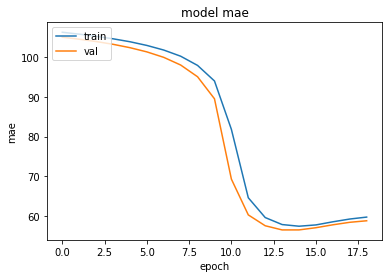

In [94]:
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
# history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

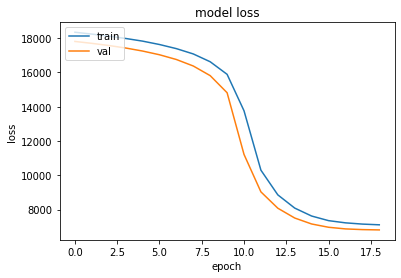

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()